# Using Variational Auto Encoder (VAE) for MNIST Augmentation

In this notebook we will be using a variational autoencoder(VAE) to augment MNIST digit images

Similar to a standard autoencoder, a variational autoencoder consists of both an encoder and a decoder, trained to minimize the reconstruction error between the encoded-decoded data and the original data. However, to introduce regularization in the latent space, we make a slight modification to the encoding-decoding process. Instead of encoding an input as a single point, we encode it as a distribution across the latent space. The model is then trained through the following steps:
* the input is encoded as distribution over the latent space
* a point from the latent space is sampled from that distribution
* the sampled point is decoded, and the reconstruction error can be computed
* the reconstruction error is then backpropagated through the network




In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Utilities

In [2]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 64
N_EPOCHS = 150

# Prepare the Dataset


In [4]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1)
    X_train = X_all[np.where(y_all == label)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset

def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

We define the following components/layers:
* Encoder, usually consisting of Convolutional Layers and Max Pooling Layers
* Decoder, usually consisting of Transposed Convolutional Layers and Upsampling Layers
* Sampling Layer, to draw a point from the distribution

In [5]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_encoder():
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    z_mean = keras.layers.Dense(CODINGS_SIZE, name="z_mean")(x)
    z_log_var = keras.layers.Dense(CODINGS_SIZE, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [7]:
def build_decoder():
    latent_inputs = keras.Input(shape=(CODINGS_SIZE,))
    x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

The loss function minimized during VAE training comprises a "reconstruction term" (on the final layer), aimed at optimizing the efficiency of the encoding-decoding process. Additionally, a "regularization term" (on the latent layer) works to regularize the organization of the latent space, ensuring that the distributions generated by the encoder closely resemble a standard normal distribution. This regularization term is quantified as the Kullback-Leibler divergence between the obtained distribution and a standard Gaussian distribution.

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Encoder Summary


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                          

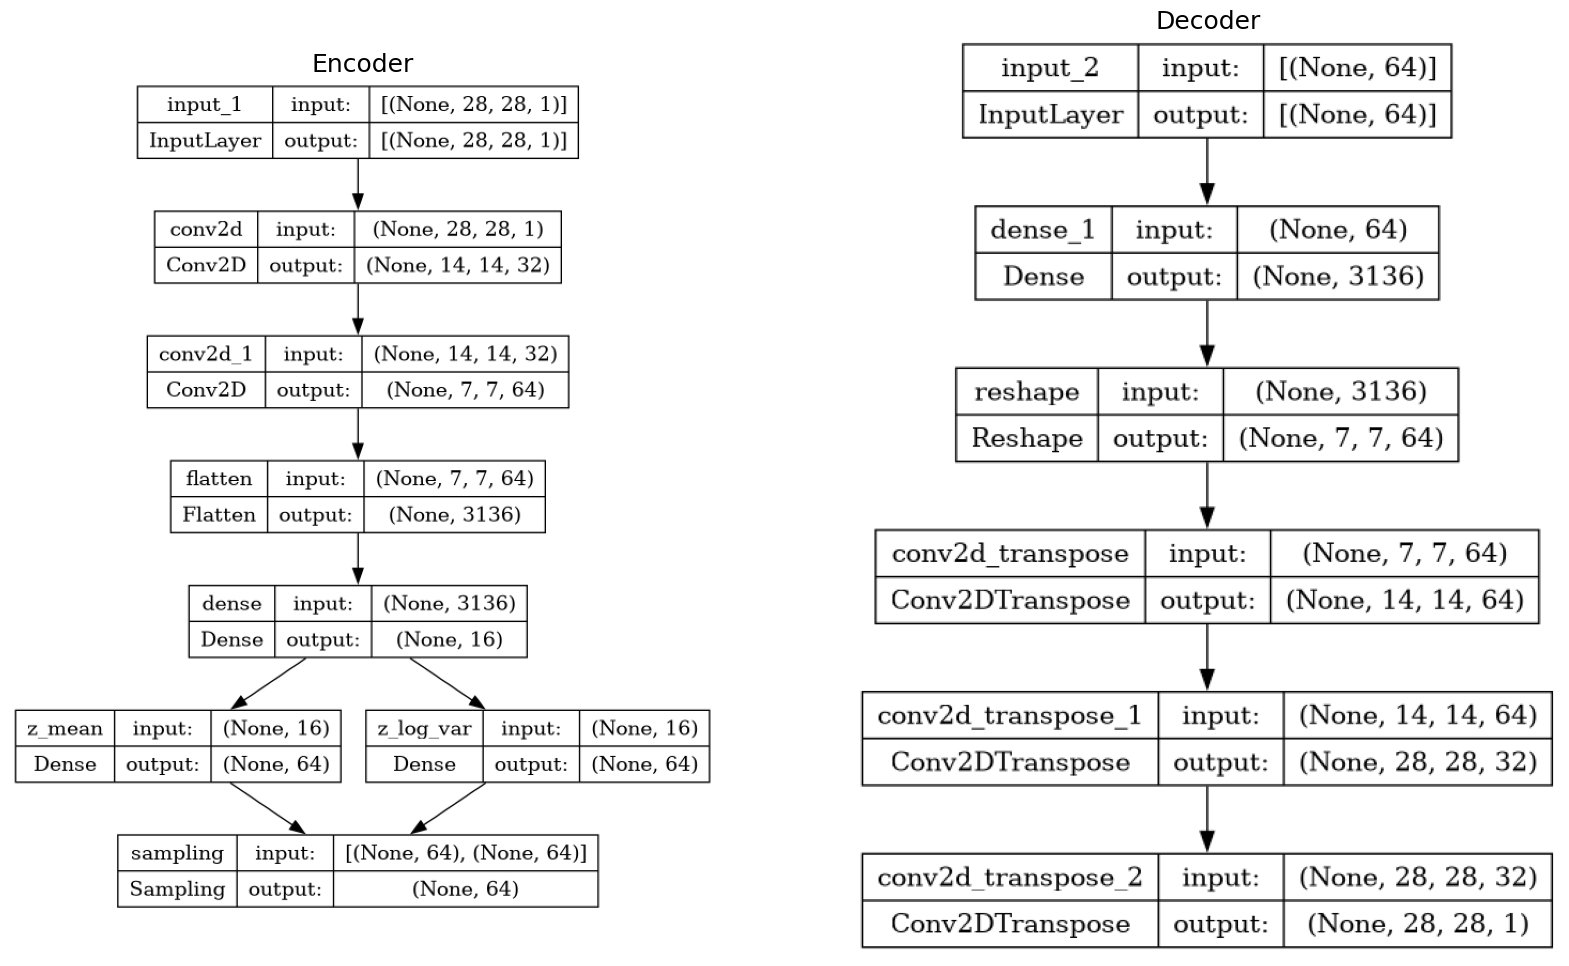

In [9]:
encoder = build_encoder()
decoder = build_decoder()
print('Encoder Summary\n\n')
encoder.summary()
print('\n\nDecoder Summary\n\n')
decoder.summary()
keras.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')
keras.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=18)
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# VAE in Action

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/150
53/53 [==============================] - 10s 6ms/step - loss: 434.4434 - reconstruction_loss: 353.9678 - kl_loss: 0.0199
Epoch 2/150
53/53 [==============================] - 0s 6ms/step - loss: 227.5920 - reconstruction_loss: 221.0103 - kl_loss: 0.1085
Epoch 3/150
53/53 [==============================] - 0s 6ms/step - loss: 215.2180 - reconstruction_loss: 213.5508 - kl_loss: 0.1454
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 212.7300 - reconstruction_loss: 211.1964 - kl_loss: 0.1681
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 211.2489 - reconstruction_loss: 209.3620 - kl_loss: 0.1799
Epoch 6/150
53/53 [==============================] - 0s 6ms/step - loss: 208.3474 - reconstruction_loss: 206.6989 - kl_loss: 0.1797
Epoch 7/150
53/53 [==============================] - 0s 6ms/step - loss: 206.2454 - reconstruction_loss: 205.2233 - kl_loss: 0.1739
Epoch 8/15

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
61/61 [==============================] - 3s 6ms/step - loss: 346.4288 - reconstruction_loss: 216.2650 - kl_loss: 4.8702
Epoch 2/150
61/61 [==============================] - 0s 6ms/step - loss: 115.9895 - reconstruction_loss: 105.9036 - kl_loss: 5.3104
Epoch 3/150
61/61 [==============================] - 0s 6ms/step - loss: 99.4382 - reconstruction_loss: 90.4742 - kl_loss: 6.3180
Epoch 4/150
61/61 [==============================] - 0s 6ms/step - loss: 92.9166 - reconstruction_loss: 83.9329 - kl_loss: 6.4082
Epoch 5/150
61/61 [==============================] - 0s 6ms/step - loss: 86.9862 - reconstruction_loss: 77.3387 - kl_loss: 6.6912
Epoch 6/150
61/61 [==============================] - 0s 6ms/step - loss: 78.5981 - reconstruction_loss: 69.4719 - kl_loss: 7.2975
Epoch 7/150
61/61 [==============================] - 0s 6ms/step - loss: 76.1006 - reconstruction_loss: 67.2482 - kl_loss: 7.5557
Epoch 8/150
61/61 [==============================] - 0s 6ms/step - loss: 74.8095 - rec

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
54/54 [==============================] - 3s 6ms/step - loss: 434.1519 - reconstruction_loss: 346.5856 - kl_loss: 0.0170
Epoch 2/150
54/54 [==============================] - 0s 6ms/step - loss: 223.1934 - reconstruction_loss: 218.5275 - kl_loss: 0.0967
Epoch 3/150
54/54 [==============================] - 0s 6ms/step - loss: 212.1876 - reconstruction_loss: 211.1692 - kl_loss: 0.1380
Epoch 4/150
54/54 [==============================] - 0s 6ms/step - loss: 209.9194 - reconstruction_loss: 209.3102 - kl_loss: 0.1529
Epoch 5/150
54/54 [==============================] - 0s 6ms/step - loss: 208.7363 - reconstruction_loss: 208.5415 - kl_loss: 0.1550
Epoch 6/150
54/54 [==============================] - 0s 6ms/step - loss: 208.2421 - reconstruction_loss: 207.7346 - kl_loss: 0.1511
Epoch 7/150
54/54 [==============================] - 0s 6ms/step - loss: 207.8945 - reconstruction_loss: 207.2942 - kl_loss: 0.1436
Epoch 8/150
54/54 [==============================] - 0s 6ms/step - loss: 206

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
55/55 [==============================] - 3s 6ms/step - loss: 395.8339 - reconstruction_loss: 293.9372 - kl_loss: 5.5692
Epoch 2/150
55/55 [==============================] - 0s 6ms/step - loss: 204.1304 - reconstruction_loss: 194.9603 - kl_loss: 5.4291
Epoch 3/150
55/55 [==============================] - 0s 6ms/step - loss: 193.0706 - reconstruction_loss: 183.6708 - kl_loss: 6.5256
Epoch 4/150
55/55 [==============================] - 0s 6ms/step - loss: 186.0558 - reconstruction_loss: 176.9113 - kl_loss: 6.8232
Epoch 5/150
55/55 [==============================] - 0s 6ms/step - loss: 178.4523 - reconstruction_loss: 168.4796 - kl_loss: 7.4488
Epoch 6/150
55/55 [==============================] - 0s 6ms/step - loss: 173.0691 - reconstruction_loss: 163.3679 - kl_loss: 8.1957
Epoch 7/150
55/55 [==============================] - 0s 6ms/step - loss: 169.0621 - reconstruction_loss: 159.9202 - kl_loss: 8.5133
Epoch 8/150
55/55 [==============================] - 0s 6ms/step - loss: 167

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
53/53 [==============================] - 3s 6ms/step - loss: 406.2549 - reconstruction_loss: 297.1215 - kl_loss: 4.3196
Epoch 2/150
53/53 [==============================] - 0s 6ms/step - loss: 191.9395 - reconstruction_loss: 184.7209 - kl_loss: 3.8331
Epoch 3/150
53/53 [==============================] - 0s 6ms/step - loss: 184.9461 - reconstruction_loss: 179.9198 - kl_loss: 3.5385
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 182.0363 - reconstruction_loss: 177.3199 - kl_loss: 3.4376
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 179.9634 - reconstruction_loss: 175.0668 - kl_loss: 3.4810
Epoch 6/150
53/53 [==============================] - 0s 6ms/step - loss: 177.3705 - reconstruction_loss: 171.6601 - kl_loss: 3.5724
Epoch 7/150
53/53 [==============================] - 0s 6ms/step - loss: 174.1862 - reconstruction_loss: 169.1880 - kl_loss: 3.5753
Epoch 8/150
53/53 [==============================] - 0s 6ms/step - loss: 171

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
49/49 [==============================] - 4s 6ms/step - loss: 413.3185 - reconstruction_loss: 310.6382 - kl_loss: 4.9175
Epoch 2/150
49/49 [==============================] - 0s 6ms/step - loss: 208.3927 - reconstruction_loss: 201.8451 - kl_loss: 4.7962
Epoch 3/150
49/49 [==============================] - 0s 6ms/step - loss: 201.8735 - reconstruction_loss: 197.6593 - kl_loss: 4.0757
Epoch 4/150
49/49 [==============================] - 0s 6ms/step - loss: 199.7458 - reconstruction_loss: 195.4888 - kl_loss: 3.8367
Epoch 5/150
49/49 [==============================] - 0s 6ms/step - loss: 197.7721 - reconstruction_loss: 193.7807 - kl_loss: 3.8530
Epoch 6/150
49/49 [==============================] - 0s 6ms/step - loss: 194.5902 - reconstruction_loss: 191.1330 - kl_loss: 4.1450
Epoch 7/150
49/49 [==============================] - 0s 6ms/step - loss: 191.2833 - reconstruction_loss: 186.8519 - kl_loss: 4.4683
Epoch 8/150
49/49 [==============================] - 0s 6ms/step - loss: 188

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
53/53 [==============================] - 3s 6ms/step - loss: 408.8490 - reconstruction_loss: 300.9221 - kl_loss: 5.3724
Epoch 2/150
53/53 [==============================] - 0s 6ms/step - loss: 199.0428 - reconstruction_loss: 190.6274 - kl_loss: 5.2855
Epoch 3/150
53/53 [==============================] - 0s 6ms/step - loss: 189.4744 - reconstruction_loss: 184.8291 - kl_loss: 4.5923
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 185.8646 - reconstruction_loss: 180.8155 - kl_loss: 4.8719
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 181.1099 - reconstruction_loss: 175.4037 - kl_loss: 5.3179
Epoch 6/150
53/53 [==============================] - 0s 6ms/step - loss: 175.2505 - reconstruction_loss: 169.4997 - kl_loss: 5.4510
Epoch 7/150
53/53 [==============================] - 0s 6ms/step - loss: 170.4573 - reconstruction_loss: 164.7931 - kl_loss: 5.5961
Epoch 8/150
53/53 [==============================] - 0s 6ms/step - loss: 166

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
56/56 [==============================] - 3s 7ms/step - loss: 372.0478 - reconstruction_loss: 260.9170 - kl_loss: 5.7780
Epoch 2/150
56/56 [==============================] - 0s 7ms/step - loss: 176.8406 - reconstruction_loss: 168.3446 - kl_loss: 5.2809
Epoch 3/150
56/56 [==============================] - 0s 6ms/step - loss: 168.1271 - reconstruction_loss: 157.9169 - kl_loss: 6.1175
Epoch 4/150
56/56 [==============================] - 0s 6ms/step - loss: 157.9438 - reconstruction_loss: 149.0906 - kl_loss: 6.8058
Epoch 5/150
56/56 [==============================] - 0s 6ms/step - loss: 152.7546 - reconstruction_loss: 143.7543 - kl_loss: 7.0060
Epoch 6/150
56/56 [==============================] - 0s 6ms/step - loss: 148.2863 - reconstruction_loss: 138.7464 - kl_loss: 7.6828
Epoch 7/150
56/56 [==============================] - 0s 6ms/step - loss: 144.9099 - reconstruction_loss: 135.7619 - kl_loss: 7.7688
Epoch 8/150
56/56 [==============================] - 0s 6ms/step - loss: 143

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
53/53 [==============================] - 3s 6ms/step - loss: 401.5090 - reconstruction_loss: 297.0758 - kl_loss: 6.3192
Epoch 2/150
53/53 [==============================] - 0s 6ms/step - loss: 207.3523 - reconstruction_loss: 199.2576 - kl_loss: 5.0159
Epoch 3/150
53/53 [==============================] - 0s 6ms/step - loss: 194.7468 - reconstruction_loss: 185.9025 - kl_loss: 6.5571
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 185.2260 - reconstruction_loss: 175.7032 - kl_loss: 7.7475
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 178.1885 - reconstruction_loss: 167.6119 - kl_loss: 8.1407
Epoch 6/150
53/53 [==============================] - 0s 6ms/step - loss: 171.2905 - reconstruction_loss: 160.0344 - kl_loss: 9.5085
Epoch 7/150
53/53 [==============================] - 0s 6ms/step - loss: 166.3620 - reconstruction_loss: 154.7014 - kl_loss: 10.8078
Epoch 8/150
53/53 [==============================] - 0s 6ms/step - loss: 16

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/150
54/54 [==============================] - 3s 6ms/step - loss: 425.8390 - reconstruction_loss: 324.7551 - kl_loss: 0.0212
Epoch 2/150
54/54 [==============================] - 0s 6ms/step - loss: 188.4155 - reconstruction_loss: 181.6564 - kl_loss: 0.1223
Epoch 3/150
54/54 [==============================] - 0s 6ms/step - loss: 177.0549 - reconstruction_loss: 173.7967 - kl_loss: 0.1689
Epoch 4/150
54/54 [==============================] - 0s 6ms/step - loss: 173.5071 - reconstruction_loss: 171.6344 - kl_loss: 0.1855
Epoch 5/150
54/54 [==============================] - 0s 6ms/step - loss: 172.4879 - reconstruction_loss: 170.2534 - kl_loss: 0.1925
Epoch 6/150
54/54 [==============================] - 0s 6ms/step - loss: 170.5958 - reconstruction_loss: 169.1979 - kl_loss: 0.1878
Epoch 7/150
54/54 [==============================] - 0s 6ms/step - loss: 169.7966 - reconstruction_loss: 168.1038 - kl_loss: 0.1795
Epoch 8/150
54/54 [==============================] - 0s 6ms/step - loss: 168

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


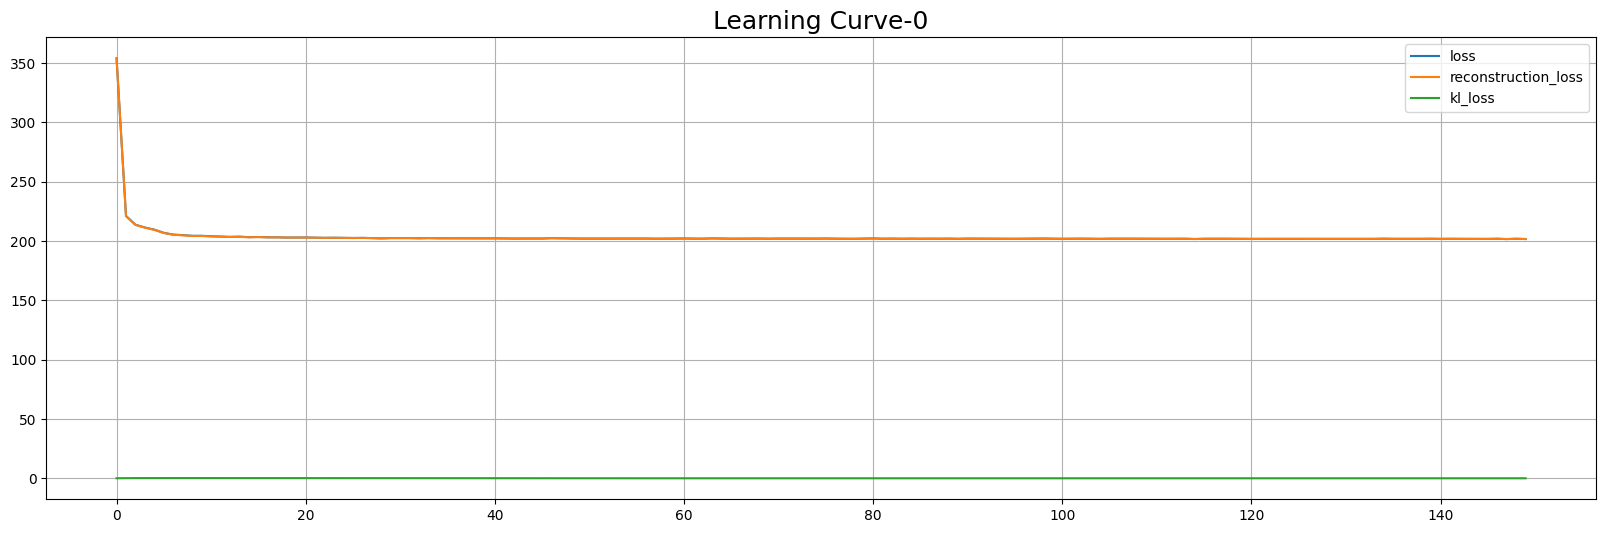

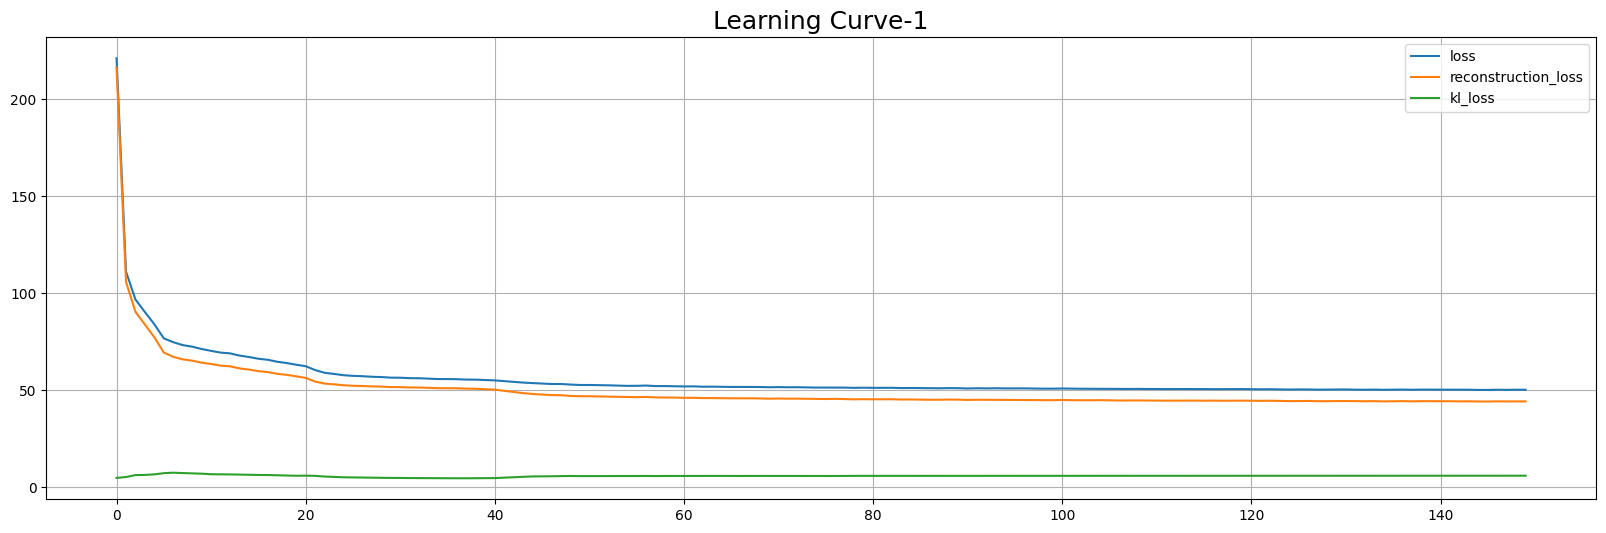

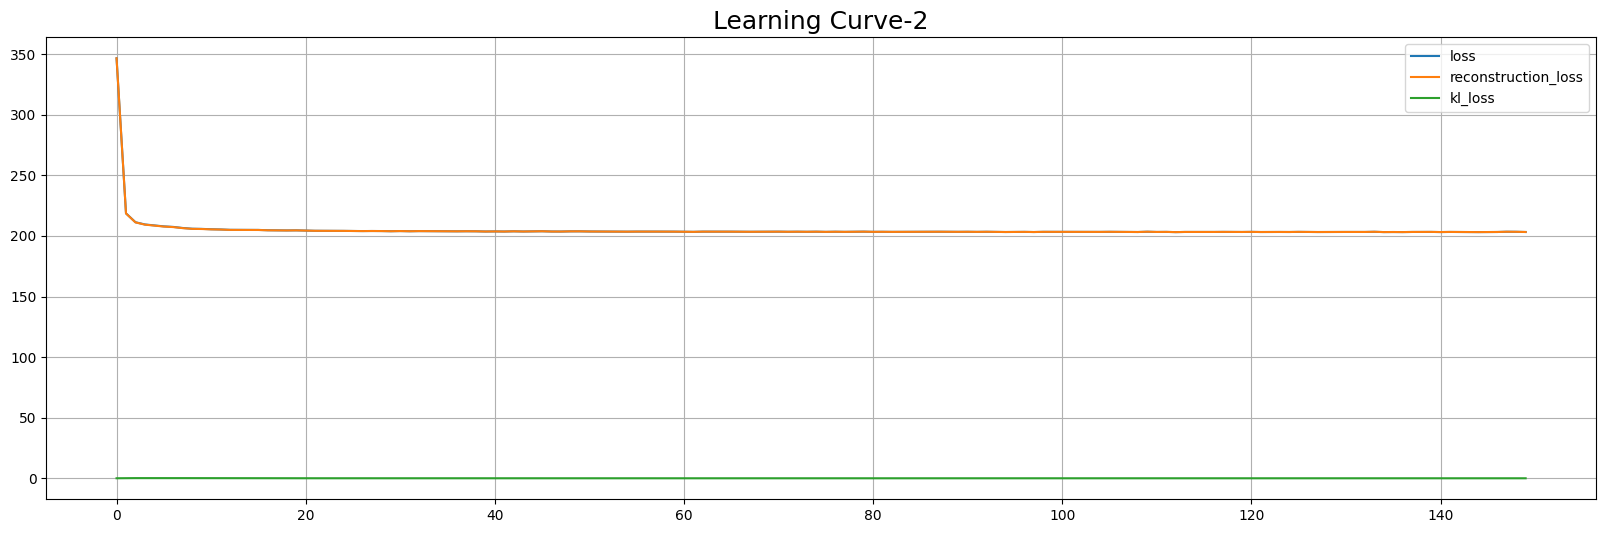

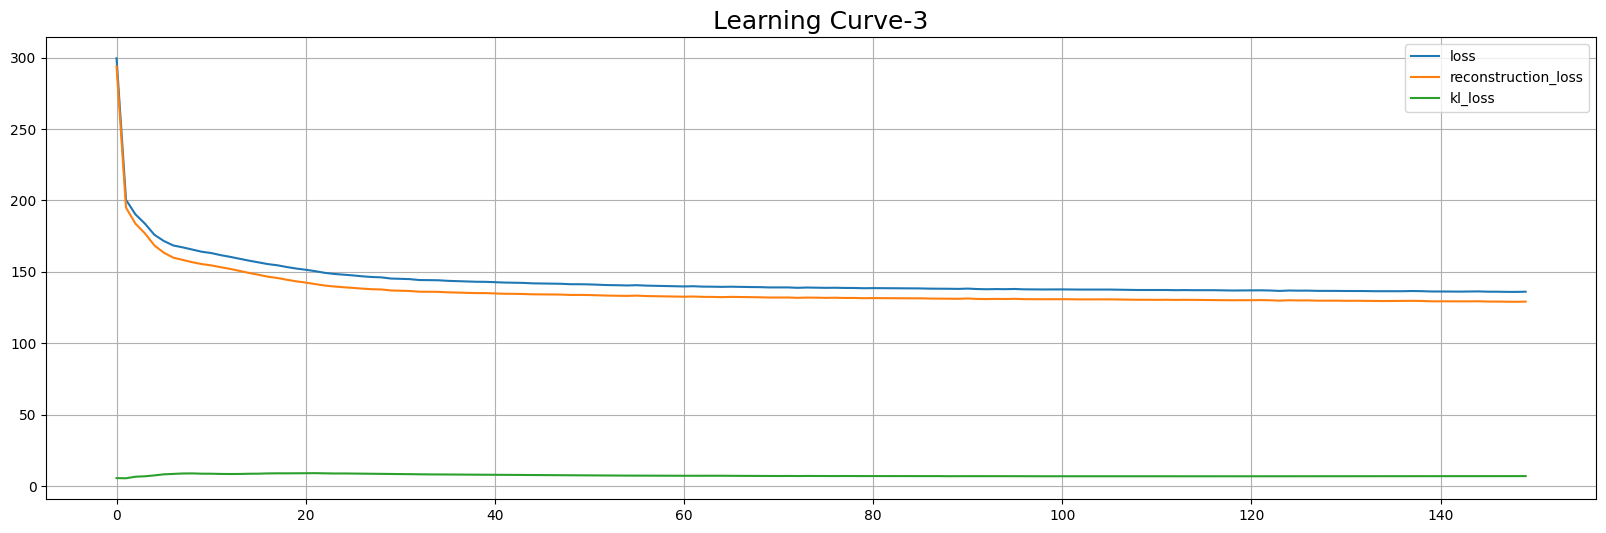

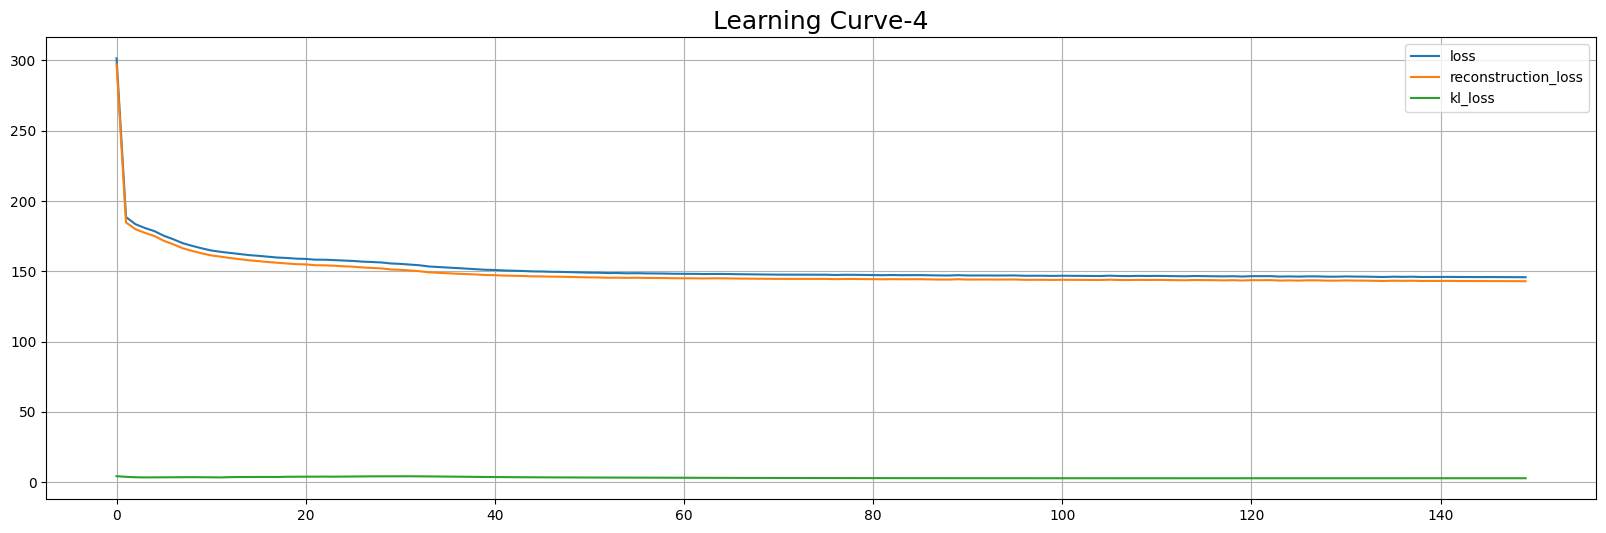

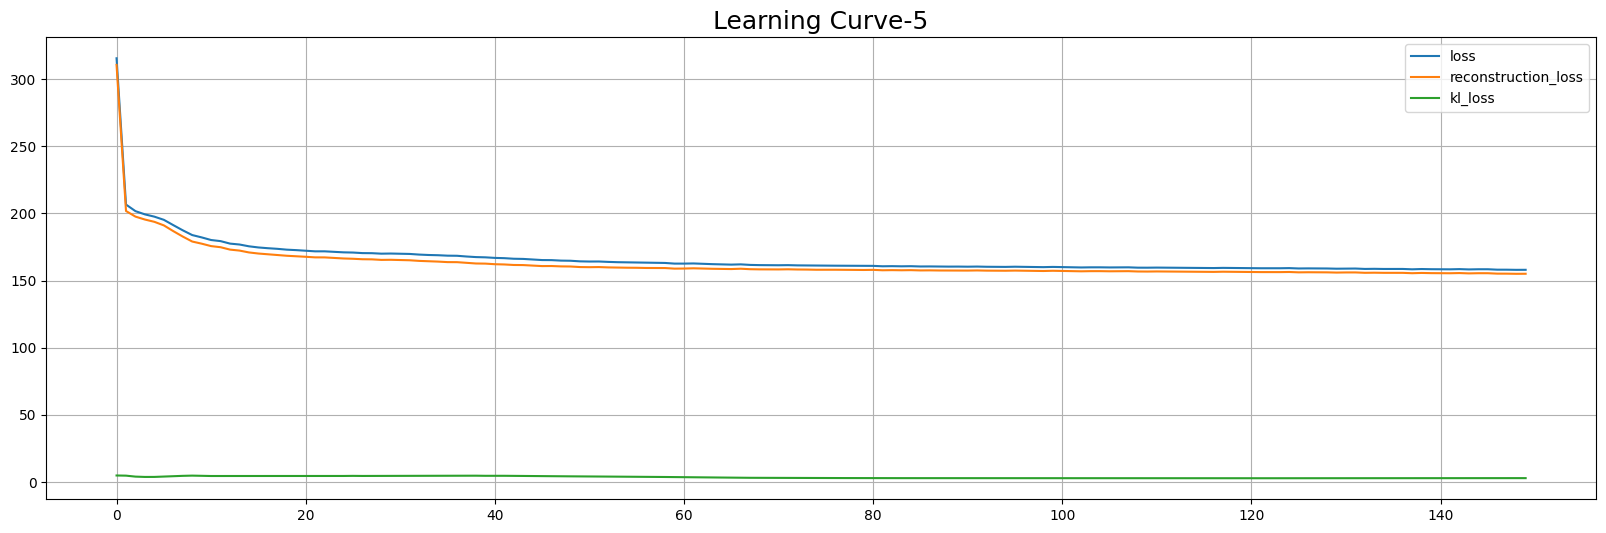

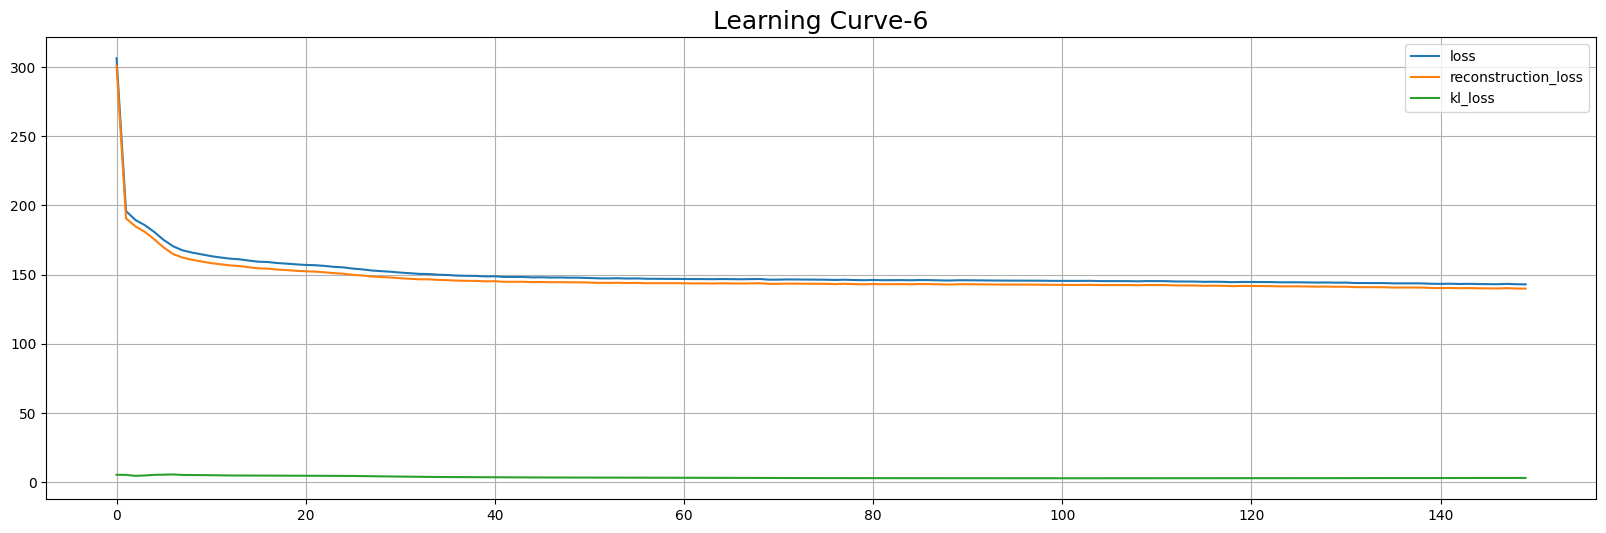

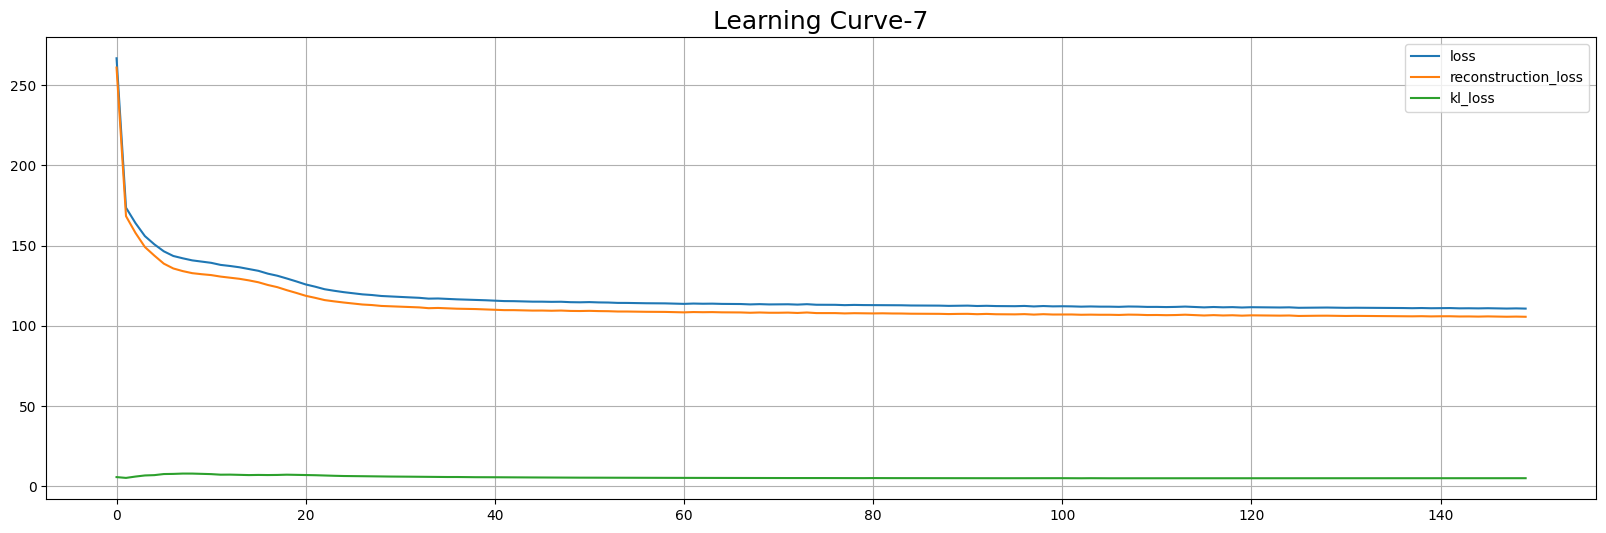

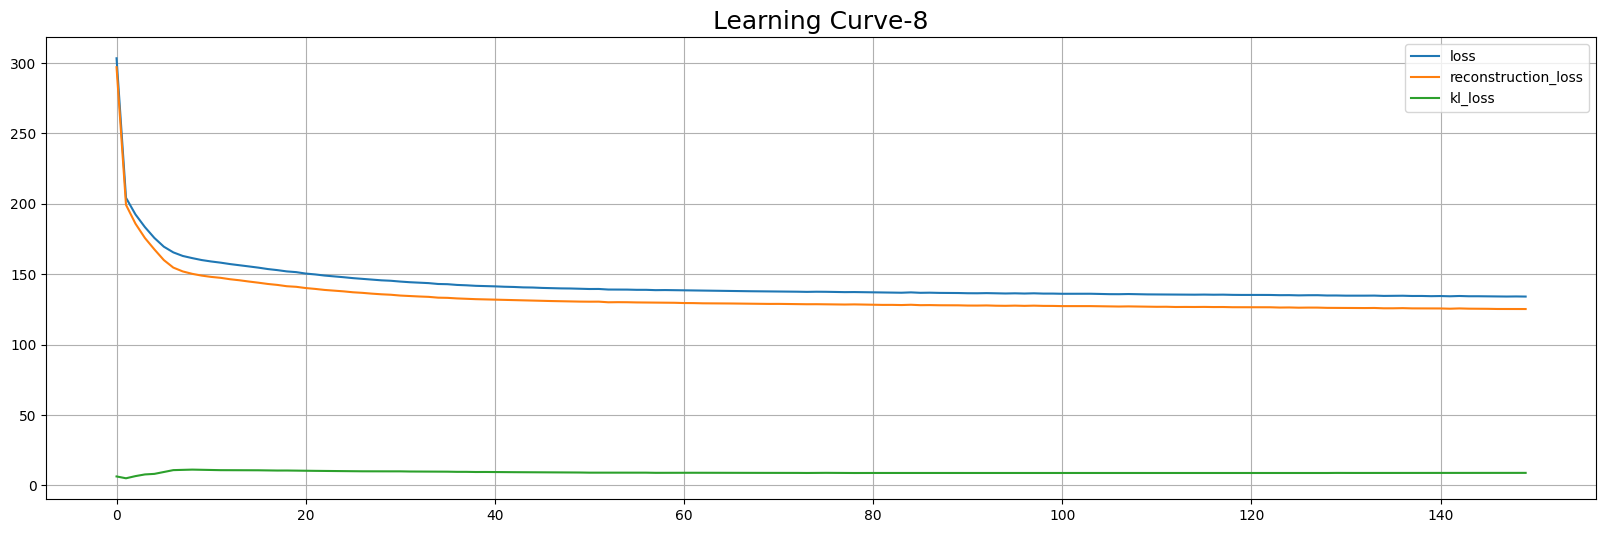

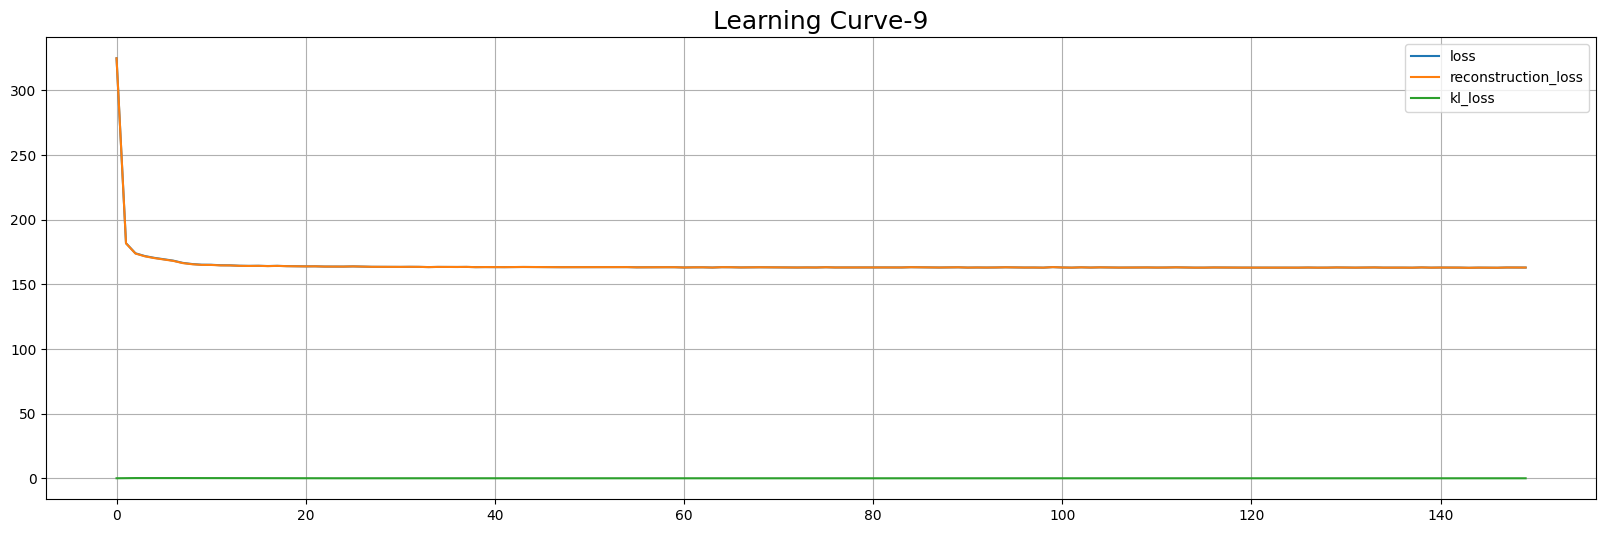

In [10]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    encoder = build_encoder()
    decoder = build_decoder()
    
    gan = VAE(
        encoder=encoder, decoder=decoder, 
    )
    gan.compile(
        keras.optimizers.Adam(learning_rate=0.001),
    )
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
       
    decoder.save(f'MNIST-AUG-VAE-{LABEL}.h5')

# Generated Images

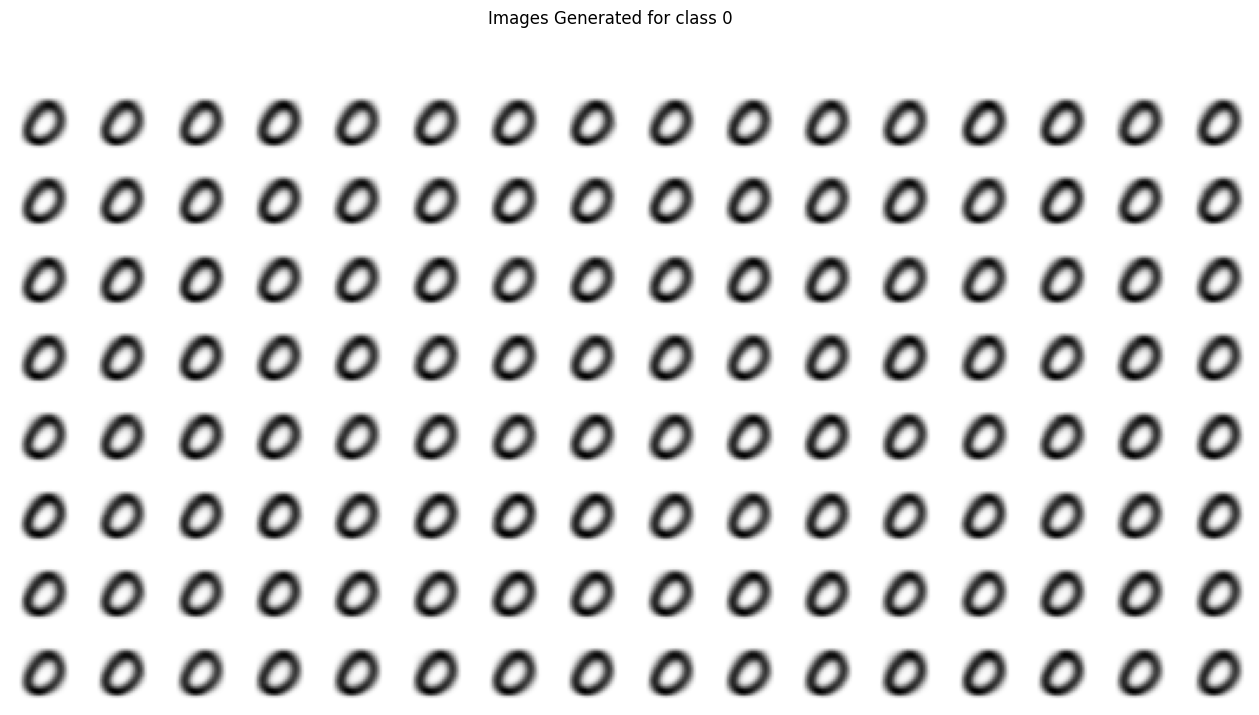

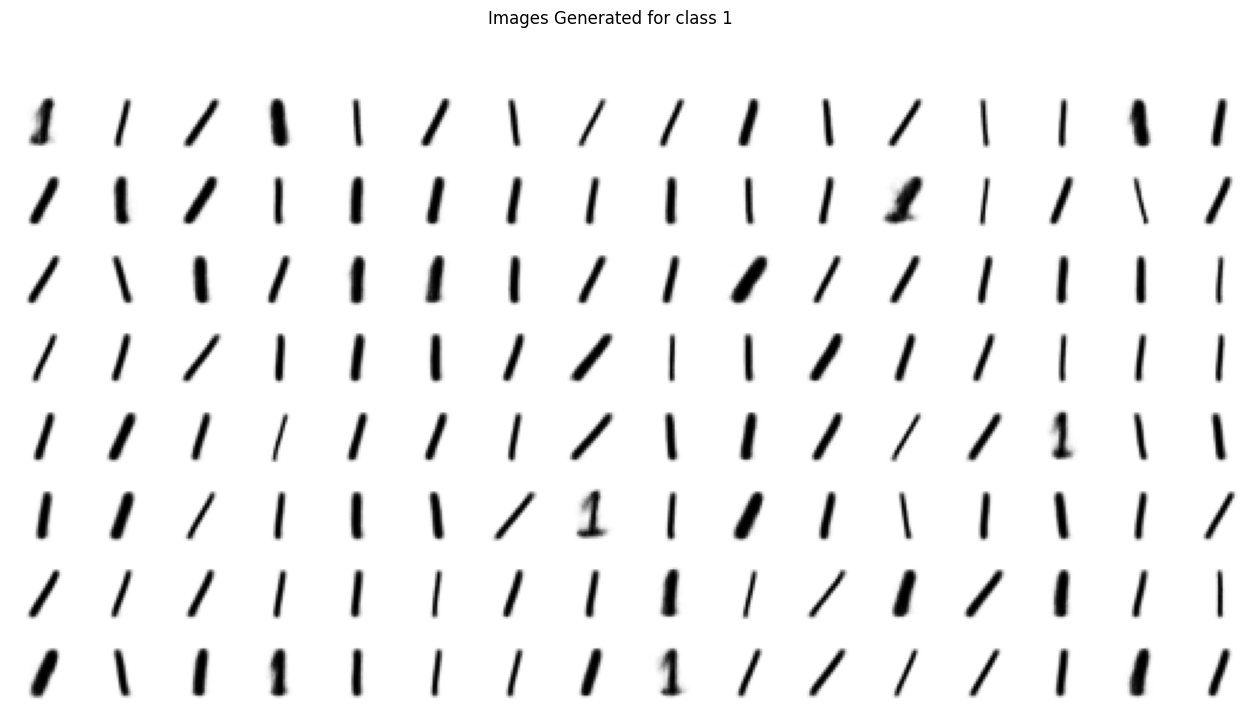

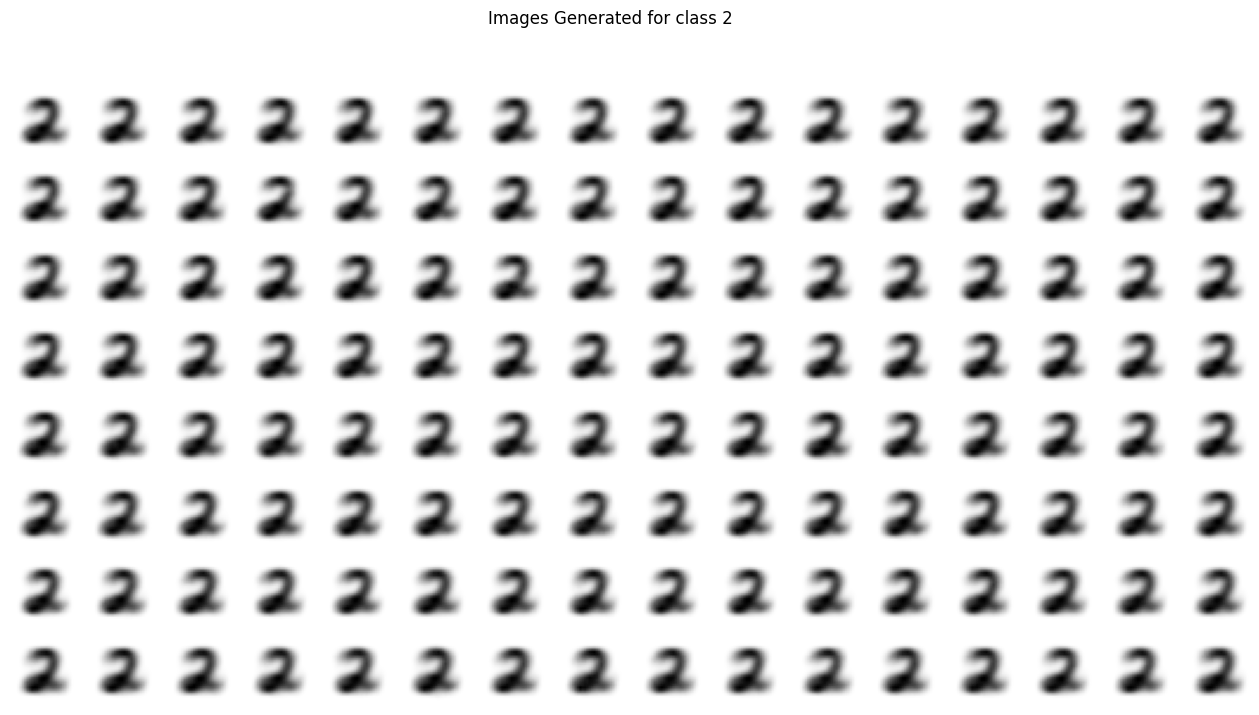

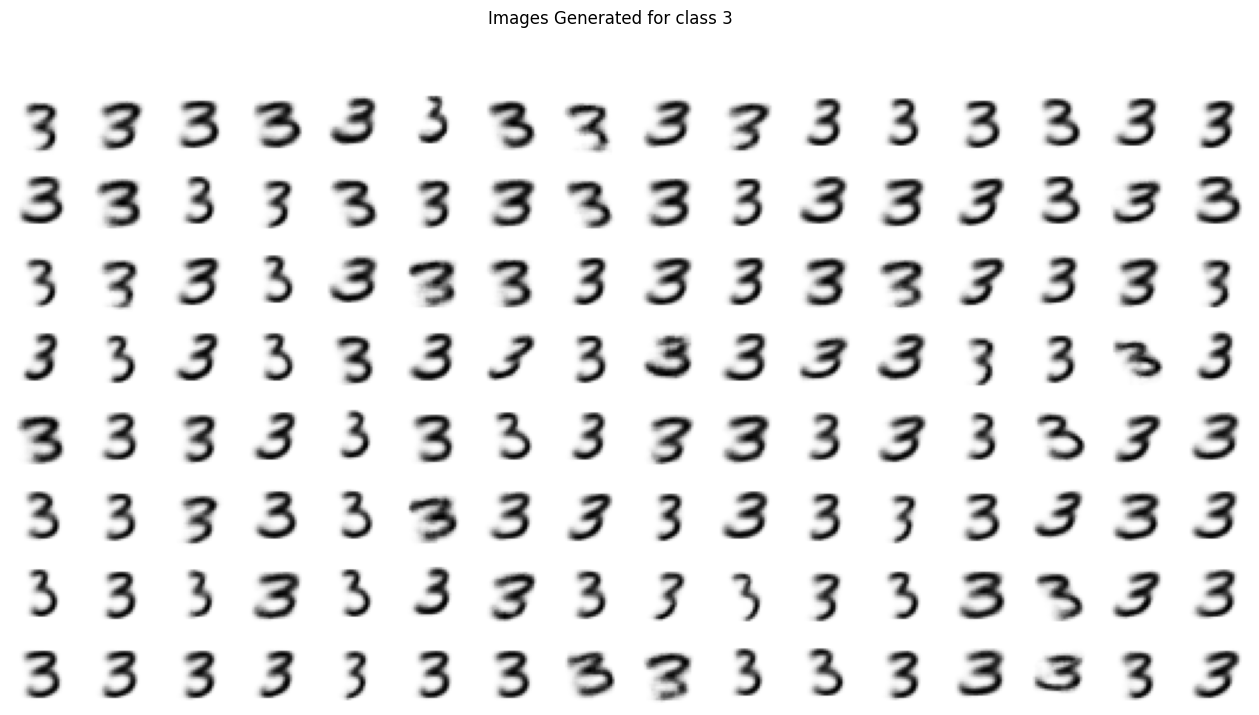

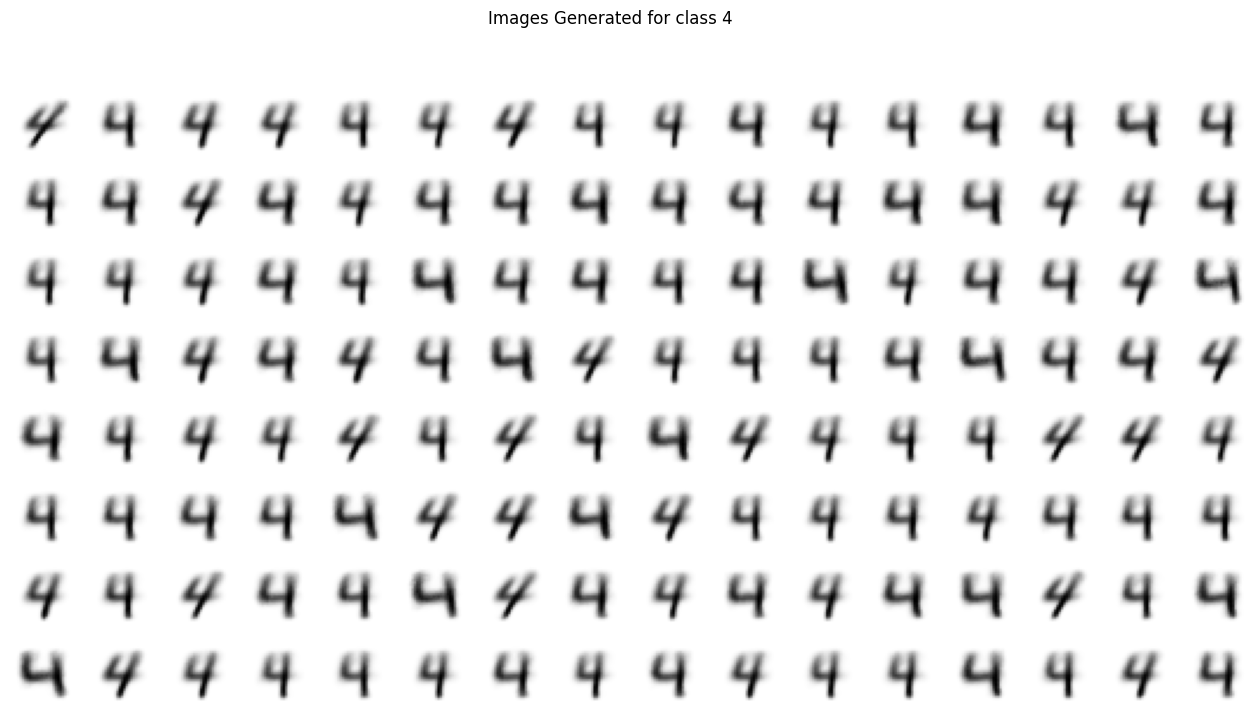

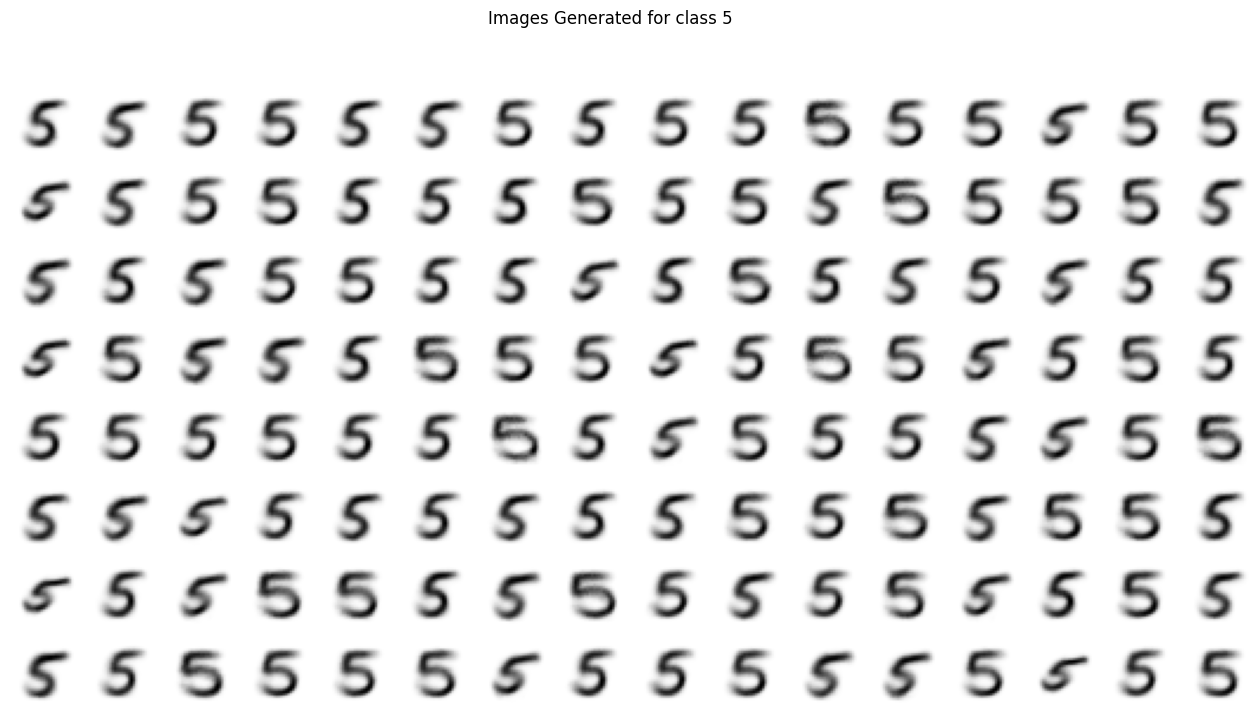

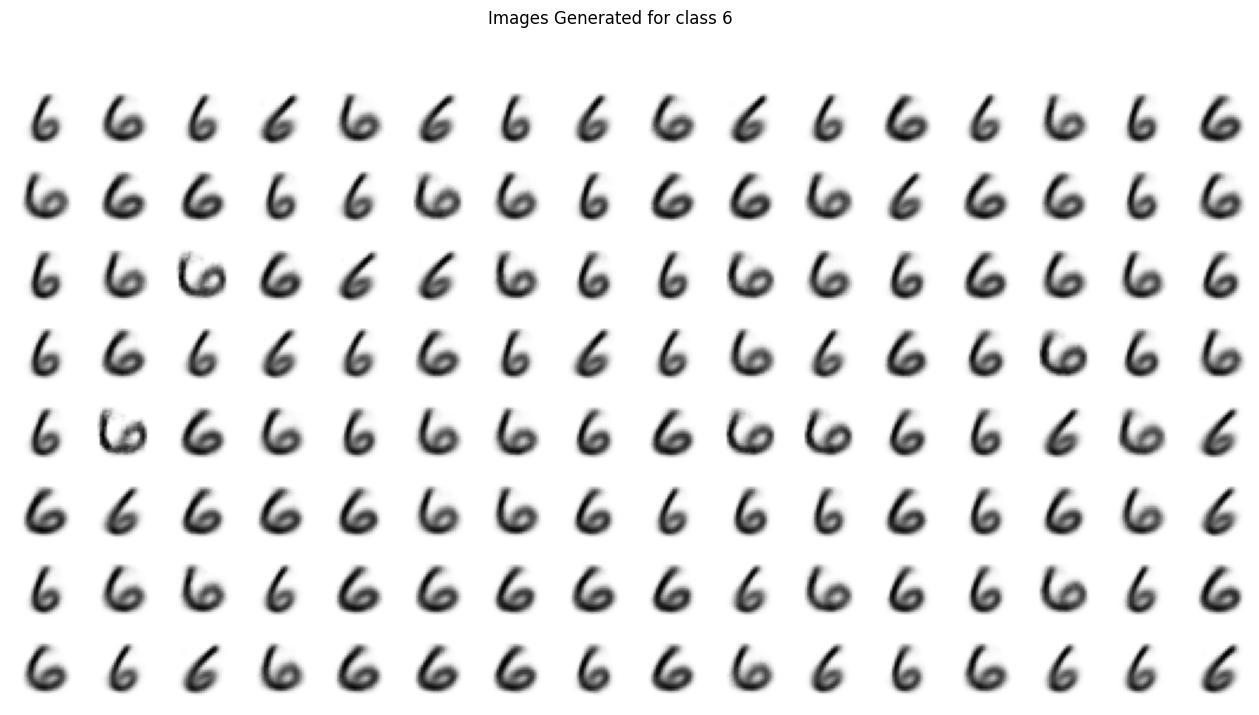

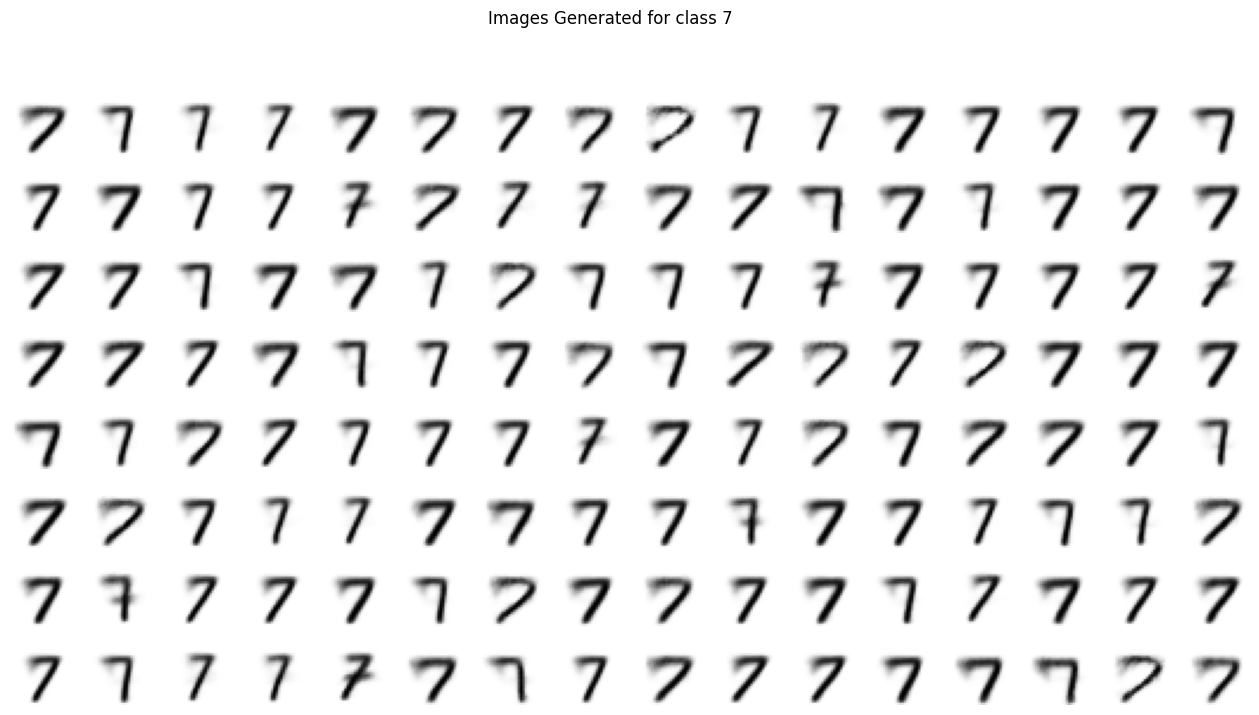

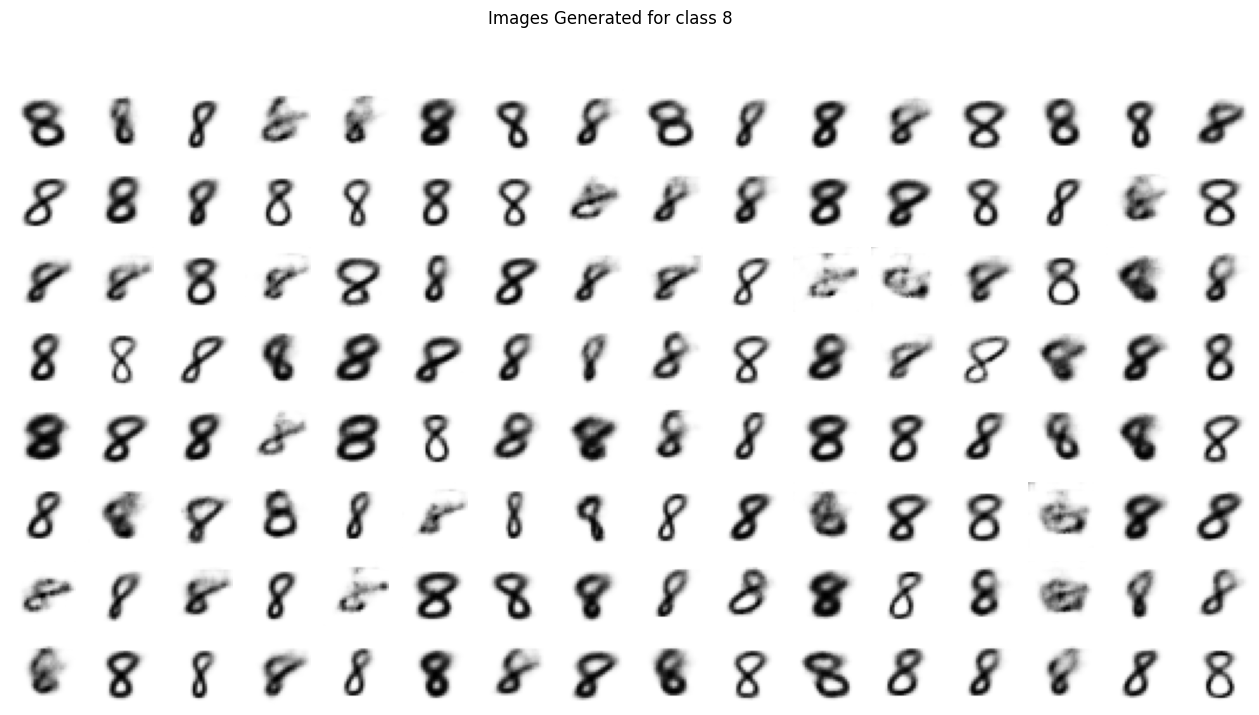

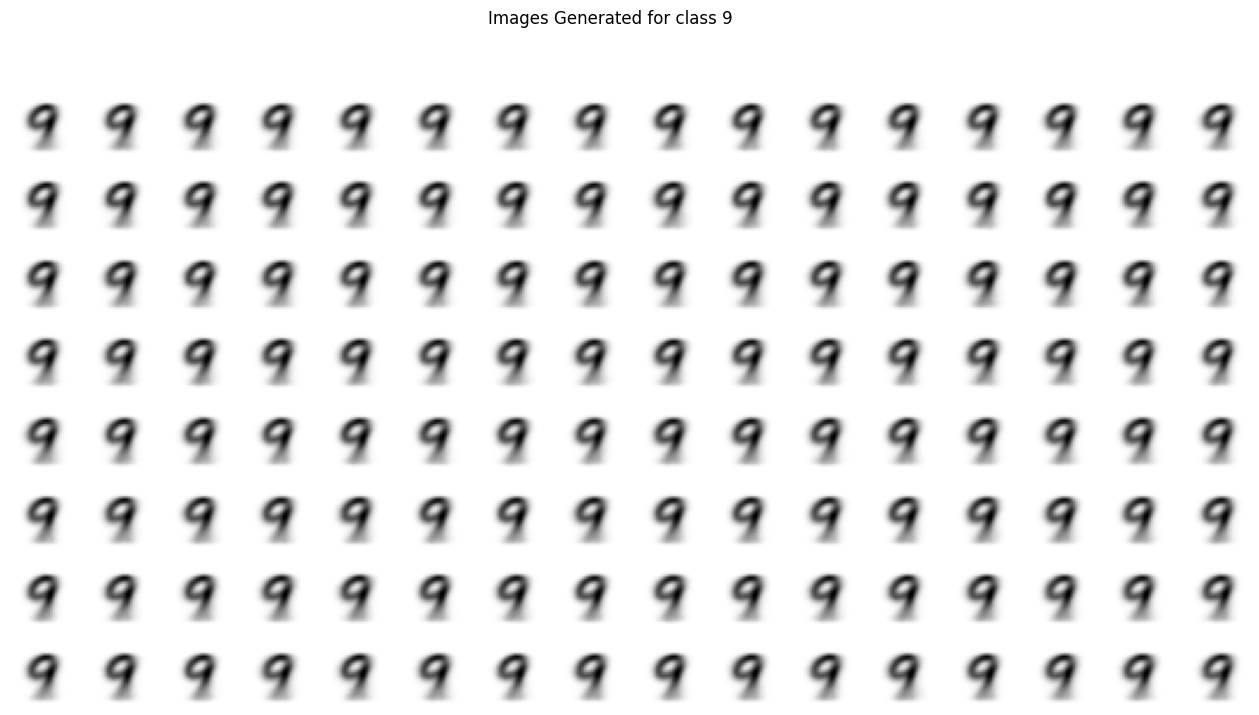

In [11]:
for i in range(10):
    decoder = keras.models.load_model(f'MNIST-AUG-VAE-{i}.h5')
    fake_images = decoder(tf.random.normal([128, CODINGS_SIZE]))
    plot_results(fake_images, 16, f'Images Generated for class {i}')
    plt.show()